# News Category Classification using RNN

##### Loading the dataset


In [2]:
import json
import numpy as np

with open('datasets/News_Category_Dataset_v3.json', 'r') as file:
    data = [json.loads(line) for line in file]

In [3]:
# view the first 5 records, in new line, format json
for i in range(5):
    print(json.dumps(data[i], indent=4))

{
    "link": "https://www.huffpost.com/entry/covid-boosters-uptake-us_n_632d719ee4b087fae6feaac9",
    "headline": "Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters",
    "category": "U.S. NEWS",
    "short_description": "Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall.",
    "authors": "Carla K. Johnson, AP",
    "date": "2022-09-23"
}
{
    "link": "https://www.huffpost.com/entry/american-airlines-passenger-banned-flight-attendant-punch-justice-department_n_632e25d3e4b0e247890329fe",
    "headline": "American Airlines Flyer Charged, Banned For Life After Punching Flight Attendant On Video",
    "category": "U.S. NEWS",
    "short_description": "He was subdued by passengers and crew when he fled to the back of the aircraft after the confrontation, according to the U.S. attorney's office in Los Angeles.",
    "authors": "Mary Papenfuss",
    "date": "20

##### Analysing the dataset

{'GOOD NEWS', 'MEDIA', 'SPORTS', 'GREEN', 'TASTE', 'FIFTY', 'STYLE & BEAUTY', 'U.S. NEWS', 'QUEER VOICES', 'WOMEN', 'HOME & LIVING', 'BLACK VOICES', 'POLITICS', 'ENVIRONMENT', 'COMEDY', 'WEIRD NEWS', 'ARTS & CULTURE', 'LATINO VOICES', 'IMPACT', 'TRAVEL', 'RELIGION', 'DIVORCE', 'STYLE', 'HEALTHY LIVING', 'CRIME', 'TECH', 'PARENTS', 'PARENTING', 'WELLNESS', 'SCIENCE', 'THE WORLDPOST', 'CULTURE & ARTS', 'WORLD NEWS', 'WEDDINGS', 'WORLDPOST', 'BUSINESS', 'ENTERTAINMENT', 'EDUCATION', 'FOOD & DRINK', 'MONEY', 'ARTS', 'COLLEGE'}
Number of categories:  42
[('POLITICS', 35602), ('WELLNESS', 17945), ('ENTERTAINMENT', 17362), ('TRAVEL', 9900), ('STYLE & BEAUTY', 9814)]


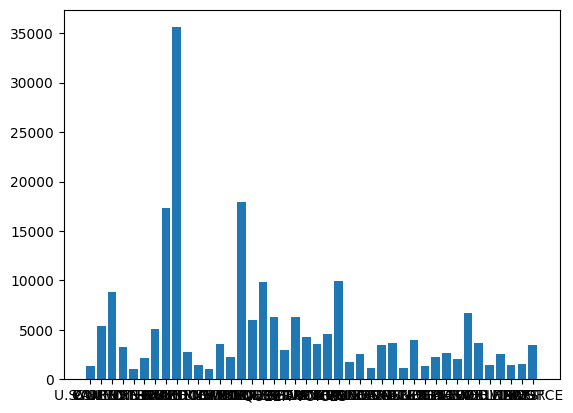

In [4]:
# view all the categories
categories = set()
for record in data:
    categories.add(record['category'])
print(categories)
print("Number of categories: ", len(categories))

# this is to be predicted

# check the distribution of the categories, plot a histogram
from collections import Counter
import matplotlib.pyplot as plt

category_count = Counter([record['category'] for record in data])

plt.bar(category_count.keys(), category_count.values())
# top 5 categories
print(category_count.most_common(5))

In [5]:
# headline vs category
headlines = [record['headline'] for record in data]
categories = [record['category'] for record in data]
# print the first 5 headlines and categories
for i in range(5):
    print(headlines[i], categories[i])

Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters U.S. NEWS
American Airlines Flyer Charged, Banned For Life After Punching Flight Attendant On Video U.S. NEWS
23 Of The Funniest Tweets About Cats And Dogs This Week (Sept. 17-23) COMEDY
The Funniest Tweets From Parents This Week (Sept. 17-23) PARENTING
Woman Who Called Cops On Black Bird-Watcher Loses Lawsuit Against Ex-Employer U.S. NEWS


In [6]:
# random seed
import random
import re

random.seed(232)
random.shuffle(data)

# prepare the data
data_truncated = [[record['headline'], record['category']] for record in data]
# preprocess the data

'''
    - lowercase
    - remove the special characters from each word
    - remove only numbers
    - remove only special characters
    - remove empty strinngs
'''
for record in data_truncated:
    headline = record[0]
    cleaned_headline = re.sub(r'[^a-z\s]+', '', headline.lower())
    record[0] = cleaned_headline


# unique words
unique_words = set([word for record in data_truncated for word in record[0].split()])
print("Number of unique words: ", len(unique_words))
# unique words of length 1
unique_words_length_1 = set([word for word in unique_words if len(word) == 1])
print("Number of unique words of length 1: ", len(unique_words_length_1))
# remove the unique words of length 1
unique_words = unique_words - unique_words_length_1
print("Number of unique words after removing unique words of length 1: ", len(unique_words))
# stemming

from nltk.stem import PorterStemmer
import nltk
stemmer = PorterStemmer()
unique_words = set([stemmer.stem(word) for word in unique_words])
# remove stopwords
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
#unique_words = unique_words - stop_words
print("Number of unique words after removing stopwords: ", len(unique_words))

# for each record if the word is in the unique words, then keep it
data_truncated = [([word for word in record[0].split() if word in unique_words], record[1]) for record in data_truncated]
print("Number of records after removing words not in unique words: ", len(data_truncated))
# from data_truncated, remove if records have words < 3
data_truncated = [record for record in data_truncated if len(record[0]) >=5 and len(record[0]) <= 15]
print("Number of records after removing records with words < 3: ", len(data_truncated))
# form unique words
unique_words = set([word for record in data_truncated for word in record[0]])
unique_words.add('')

Number of unique words:  66849
Number of unique words of length 1:  26
Number of unique words after removing unique words of length 1:  66823
Number of unique words after removing stopwords:  46798
Number of records after removing words not in unique words:  209527
Number of records after removing records with words < 3:  151776


In [7]:
# index the words and categories. Embedding layer requires the input to be in the form of integers

vocab_size = len(unique_words)
categories = len(set(record[1] for record in data_truncated))

category_to_index = {category: i for i, category in enumerate(set(record[1] for record in data_truncated))}
word_to_index = {word: i for i, word in enumerate(unique_words)}
index_to_word = {i: word for i, word in enumerate(unique_words)}

data_truncated = [[record[0], category_to_index[record[1]]] for record in data_truncated]

MAX_LENGTH = max(len(record[0]) for record in data_truncated)
for record in data_truncated:
    record[0] += [''] * (MAX_LENGTH - len(record[0]))
    record[0] = [word_to_index[word] for word in record[0]]


In [8]:
# split the data into training and testing
split_ratio = 0.8
split_index = int(len(data_truncated) * split_ratio)

train_data = data_truncated[:split_index]
test_data = data_truncated[split_index:]

print("training data: ", len(train_data))
print("testing data: ", len(test_data))

training data:  121420
testing data:  30356


In [9]:

import torch

# INITIALIZE THE PARAMETERS
EMBEDDING_DIM = 10
embeddings = torch.randn(vocab_size, EMBEDDING_DIM)/np.sqrt(vocab_size)
HIDDEN_LAYER_DIM = 50

# rnn weights

# TODO: kaiming initialization, currently using xavier initialization
W = torch.randn(EMBEDDING_DIM, HIDDEN_LAYER_DIM)/np.sqrt(EMBEDDING_DIM)
U = torch.randn(HIDDEN_LAYER_DIM, HIDDEN_LAYER_DIM)/np.sqrt(HIDDEN_LAYER_DIM)

# feed forward network
W1 = torch.randn(HIDDEN_LAYER_DIM, HIDDEN_LAYER_DIM)/np.sqrt(HIDDEN_LAYER_DIM)
b1 = torch.randn(HIDDEN_LAYER_DIM)/np.sqrt(HIDDEN_LAYER_DIM)
W2 = torch.randn(HIDDEN_LAYER_DIM, categories)/np.sqrt(HIDDEN_LAYER_DIM)
b2 = torch.randn(categories)/np.sqrt(HIDDEN_LAYER_DIM)

# set the requires_grad to True
parameters = [W, U, W1, b1, W2, b2, embeddings]
for parameter in parameters:
    parameter.requires_grad = True



In [12]:

BATCH_SIZE = 30

for _ in range(10000):
    batch  = random.sample(train_data, BATCH_SIZE)
    X = [record[0] for record in batch]
    y = [record[1] for record in batch]
    
    h_t = torch.zeros(BATCH_SIZE, HIDDEN_LAYER_DIM)
    h_t.requires_grad = True
    for index in range(15):
        x_i = [[record[index] for record in X]]
        emb = embeddings[x_i]
        h_t = torch.tanh(emb @ W + h_t @ U)
    # layer1
    h1 = torch.tanh(h_t @ W1 + b1)
    # layer2
    logits = h1 @ W2 + b2
    # softmax    
    # to add: numerical stability ? why? - to avoid overflow of the exponential function
    logits_maxes = logits.max(1, keepdim=True).values  # keepdims=True, other wise squished to 1D, and not broadcasted
    logits_norm = logits - logits_maxes
    counts = logits_norm.exp()
    #print(counts)
    #print(counts.shape)
    counts_sum_inv = counts.sum(1, keepdim=True)
    #print(counts_sum_inv)
    y_prob = counts * counts_sum_inv**-1
    # loss (only for one record at a time, not for a batch)
    logprobs = y_prob.log()
    loss = -logprobs[range(BATCH_SIZE), y].mean()
    # backpropagation
    for parameter in parameters:
        parameter.grad = None
    
    loss.backward()

    # update the parameters
    for parameter in parameters:
        parameter.data -= 0.005 * parameter.grad

print(loss)

tensor(2.4074, grad_fn=<NegBackward0>)


In [13]:
# test the model
correct = 0
total = 0
for record in test_data:
    X = record[0]
    y = record[1]
    h_t = torch.zeros(1, HIDDEN_LAYER_DIM)
    for index in range(15):
        x_i = X[index]
        emb = embeddings[x_i]
        h_t = torch.tanh(emb @ W + h_t @ U)
    h1 = torch.tanh(h_t @ W1 + b1)
    logits = h1 @ W2 + b2
    y_pred = logits.argmax().item()
    if y_pred == y:
        correct += 1
    total += 1
print("Accuracy: ", correct/total)
print("Number of test records: ", total)
print("Number of correct predictions: ", correct)
# save the model
torch.save({
    'W': W,
    'U': U,
    'W1': W1,
    'b1': b1,
    'W2': W2,
    'b2': b2,
    'embeddings': embeddings
}, 'model.pth')


Accuracy:  0.3754776650415074
Number of test records:  30356
Number of correct predictions:  11398


### Results

- Basic RNN model, giving a baseline of 2.8 negative log likelihood. With accuracy of 37% on the test set.
    - Xavier initialization
    - Simple stochastic gradient descent
    - Batch size of 30, and embedding size of 10
    - Contains 15 time steps, and a two layer feedforward network for classification

### TODO

- Investigate where the model is failing
- Investigate the effect of the embedding size on the model performance
- Investigate the effect of the number of time steps on the model performance
- Different performance metrics


### Ideas 
- Average the word embeddings for each time step, and then pass it through the feedforward network? 
- Deepeing the network? Why or why not?


